In [2]:
SMALL_SIZE, MEDIUM_SIZE = 9, 12
PROJECT_PATH = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"

In [3]:
import sys
import numpy as np
from glob import glob
import random, matplotlib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

sys.path.append(PROJECT_PATH)
from utils.data import Dataset


In [4]:
import utils.figure as ufigure
%load_ext autoreload
%autoreload 1
%aimport utils.data
%aimport utils.figure

In [5]:
Data = Dataset(PROJECT_PATH, 'final')
Data.load_data()

Loading INFO.yaml ...
Finished loading INFO
Loading config.yaml ...


  2%|▏         | 3/141 [00:00<00:07, 17.28it/s]

Finished loading config


100%|██████████| 141/141 [00:34<00:00,  4.07it/s]


In [6]:
# configuration
INFO = Data.info
INFO_values = Data.info_values
config = Data.config
skeleton = config['skeleton']
skeleton_color= config['skeleton_color']

# features
bp = Data.data_obj['bodypoints']
rot_bp = Data.data_obj['rotated_bodypoints']
angles = Data.data_obj['angles']
limbs = Data.data_obj['limbs']
angle_power = Data.data_obj['angle_power']
limb_power = Data.data_obj['limb_power']

# embeddings
all_embed = Data.data_obj['all_embeddings']
all_postural_embed = Data.data_obj['all_postural_embeddings']
all_kinematic_embed = Data.data_obj['all_kinematic_embeddings']

# cluster
cluster = Data.data_obj['cluster']

In [113]:
np.savetxt("all_feature_embedding.csv", all_embed, delimiter=",")

<hr><hr>

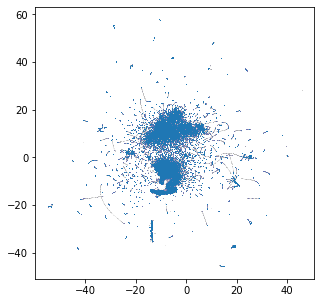

In [7]:
fig_all_embed, ax_base = plt.subplots(1,1,figsize=(5,5))
ax_base.scatter(all_embed[:,0], all_embed[:,1], s=1, alpha=0.005)
plt.show()

<hr><hr>

In [8]:
caste_data = {"min": [], "mid": [], "maj":[]}
env_data = {"food": [], "free":[]}

caste_cluster = {"min": [], "mid": [], "maj":[]}
env_cluster = {"food": [], "free": []}

for item in INFO_values:
    path = item['directory']
    start, stop = item['global_start_fr'], item['global_stop_fr']

    # Caste Condition
    if path.find("min") is not -1:
        caste_data["min"].extend(all_embed[start:stop].tolist())
        caste_cluster["min"].extend(cluster[start:stop].tolist())
    if path.find("mid") is not -1:
        caste_data["mid"].extend(all_embed[start:stop].tolist())
        caste_cluster["mid"].extend(cluster[start:stop].tolist())
    if path.find("maj") is not -1:
        caste_data["maj"].extend(all_embed[start:stop].tolist())
        caste_cluster["maj"].extend(cluster[start:stop].tolist())
    
    # Environmental Conditions
    if path.find("fd") is not -1:
        env_data["food"].extend(all_embed[start:stop].tolist())
        env_cluster["food"].extend(cluster[start:stop].tolist())
    if path.find("fr") is not -1:
        env_data["free"].extend(all_embed[start:stop].tolist())
        env_cluster["free"].extend(cluster[start:stop].tolist())

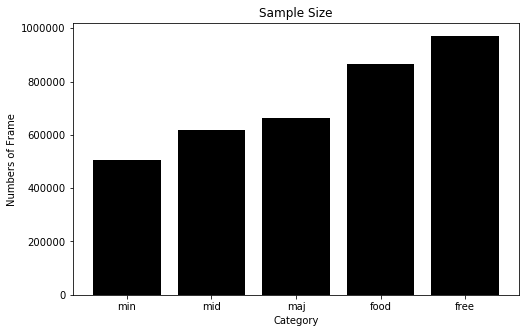

In [8]:
data_type = []
type_num_fr = []

fig, ax = plt.subplots(figsize=(8, 5))
for key, val in caste_data.items():
    data_type.append(key)
    type_num_fr.append(len(val))
for key, val in env_data.items():
    data_type.append(key)
    type_num_fr.append(len(val))
    
ax.bar(data_type, type_num_fr, color='k')
ax.set(xlabel='Category', ylabel='Numbers of Frame', title="Sample Size")
plt.show()

(505934, 2)
(618586, 2)
(661457, 2)


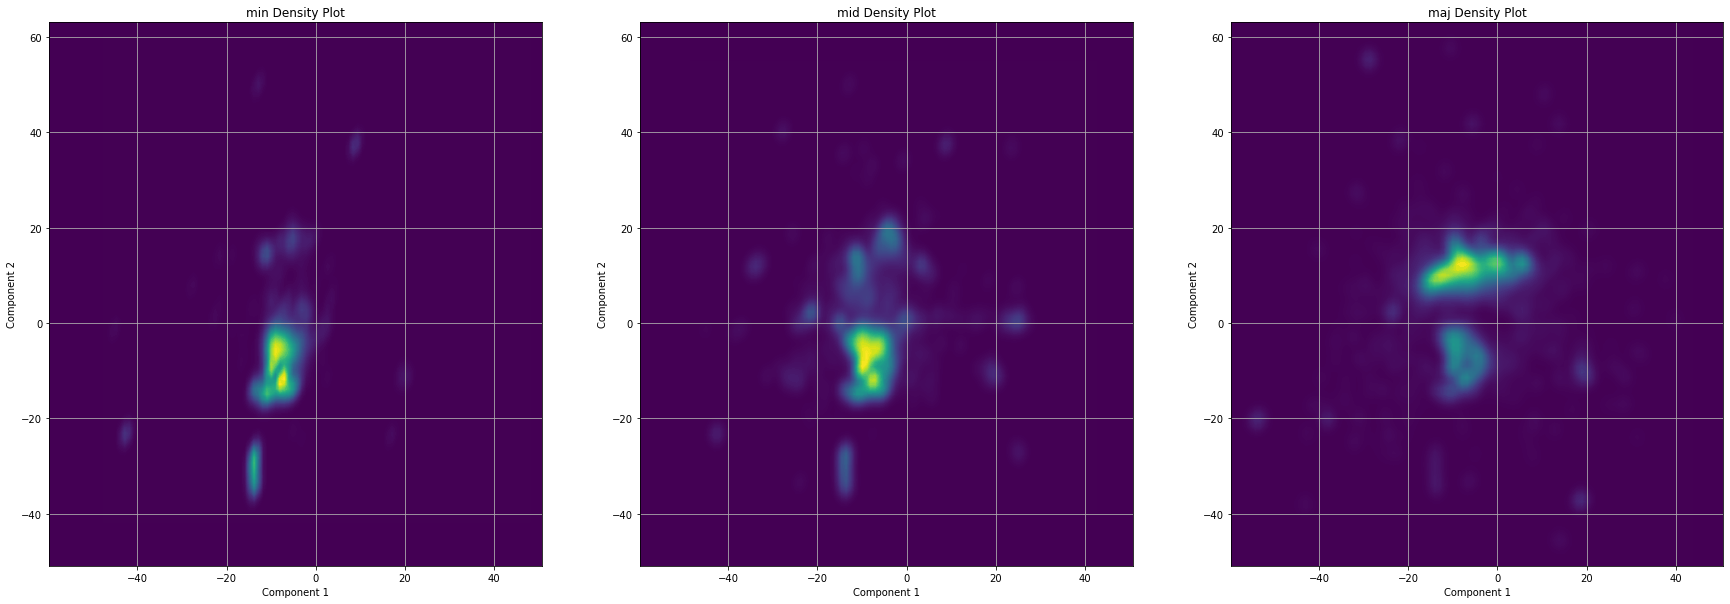

In [24]:
import seaborn as sns

# caste
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
for idx, (key, cat_embed) in enumerate(caste_data.items()):
    cat_embed = np.array(cat_embed)
    print(cat_embed.shape)
    num_fr,_ = cat_embed.shape
    nan_fr,_ = np.where(np.isnan(cat_embed))
    bad_fr = np.unique(nan_fr)
    good_fr = np.array([True]*num_fr)
    good_fr[bad_fr] = False
    # density
    sns.kdeplot(x=cat_embed[good_fr,0], y=cat_embed[good_fr,1], 
            shade=True, thresh=0, gridsize=100, bw_adjust=1,
            levels=100, cmap='viridis',
            cbar=False, ax=ax[idx])
    
    ax[idx].set(xlabel='Component 1', ylabel='Component 2', 
                title=f"{key} Density Plot", facecolor='#440054',
               xlim=ax_base.get_xlim(), ylim=ax_base.get_ylim()) # , facecolor='#000096'
    ax[idx].grid(which="major")
plt.show()

(865481, 2)
(970894, 2)


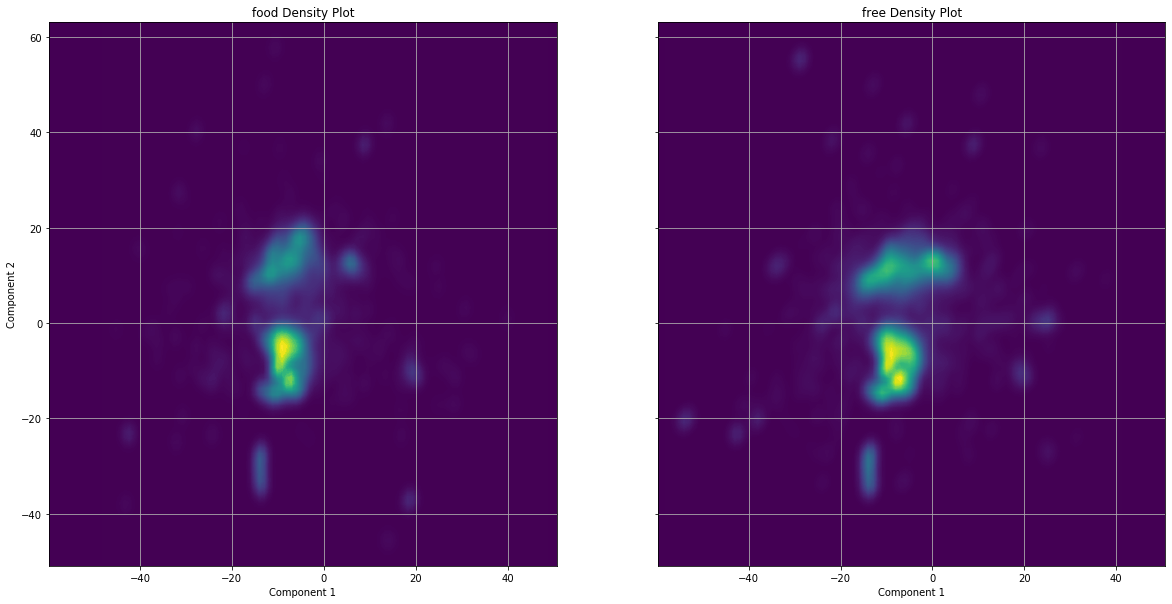

In [25]:
# Environment

fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
for idx, (key, cat_embed) in enumerate(env_data.items()):
    cat_embed = np.array(cat_embed)
    print(cat_embed.shape)
    num_fr,_ = cat_embed.shape
    nan_fr,_ = np.where(np.isnan(cat_embed))
    bad_fr = np.unique(nan_fr)
    good_fr = np.array([True]*num_fr)
    good_fr[bad_fr] = False
    # density
    sns.kdeplot(x=cat_embed[good_fr,0], y=cat_embed[good_fr,1], 
            shade=True, thresh=0, gridsize=100, bw_adjust=1,
            levels=100, cmap='viridis',
            cbar=False, ax=ax[idx])
    
    ax[idx].set(xlabel='Component 1', ylabel='Component 2', 
                title=f"{key} Density Plot", facecolor='#440054',
               xlim=ax_base.get_xlim(), ylim=ax_base.get_ylim()) # , facecolor='#000096'
    ax[idx].grid(which="major")
plt.show()

# Motif Usage

In [9]:
import collections

In [10]:
num_clusters = np.max(cluster) + 1
caste_motif = {"min": [], "mid": [], "maj":[]}

for key in caste_cluster.keys():
    print(key)
    
    for clust_id in np.arange(-2,num_clusters):
        clust_fr, = np.where( caste_cluster[key]==clust_id )
        caste_motif[key].append(len(clust_fr))
    
    cluster_num_fr_norm = 100*np.array(caste_motif[key])/np.sum(caste_motif[key])
    caste_motif[key] = cluster_num_fr_norm
    print(caste_motif)

min
{'min': array([6.30797693e+01, 2.10934628e+01, 0.00000000e+00, 6.91789838e-02,
       3.41151217e-01, 3.94913170e-01, 7.11555262e-01, 5.27736819e-01,
       1.84016097e-01, 0.00000000e+00, 8.87467535e-02, 1.07899449e+00,
       6.81907126e-02, 1.75912273e-02, 5.07180779e-01, 8.30740769e-01,
       3.93331937e-02, 0.00000000e+00, 5.11133863e-01, 1.93898809e-01,
       2.37382742e-01, 1.16616001e-02, 2.02595595e-01, 3.89378852e-02,
       6.60758123e-01, 1.45552582e+00, 7.83699060e-01, 2.03583867e-02,
       4.21794147e-01, 4.70417090e-02, 1.73540422e-01, 2.66833223e-02,
       3.66846268e-01, 3.67636885e-01, 2.52997427e-02, 1.40334510e-02,
       6.34470109e-02, 1.34404883e-02, 4.09144276e-02, 0.00000000e+00,
       2.49044342e-02, 2.92528274e-02, 0.00000000e+00, 5.33666447e-03,
       4.23770689e-01, 5.57582610e-01, 4.42152534e-01, 4.00842798e-01,
       3.36209861e-01, 2.04572138e-01, 3.63486146e-01, 7.25984022e-01,
       4.43733768e-01, 8.32717311e-01, 5.00262880e-01]), 'mid': [

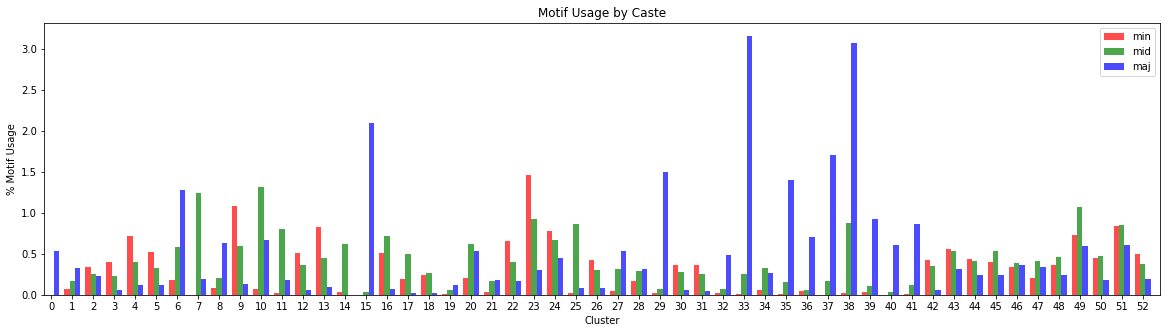

In [159]:
# Distribution figure  
cluster_id = np.arange(0,num_clusters*12)
width = 3

fig, ax = plt.subplots(figsize=(20,5)) 
ax.bar(cluster_id[0::12], caste_motif['min'][2:],color='red',width=width,label='min',alpha=0.7)
ax.bar(cluster_id[3::12], caste_motif['mid'][2:],color='green',width=width,label='mid',alpha=0.7)
ax.bar(cluster_id[6::12], caste_motif['maj'][2:],color='blue',width=width,label='maj',alpha=0.7)
ax.set(xlabel="Cluster", ylabel="% Motif Usage", title="Motif Usage by Caste", 
       xticks=cluster_id[3::12], xticklabels=np.arange(0,num_clusters).astype(int),
      xlim=[-1,num_clusters*12+1])
plt.legend()
plt.show()

In [11]:
num_clusters = np.max(cluster) + 1
env_motif = {"food": [], "free": []}

for key in env_cluster.keys():
    print(key)
    
    for clust_id in np.arange(-2,num_clusters):
        clust_fr, = np.where( env_cluster[key]==clust_id )
        env_motif[key].append(len(clust_fr))
    
    cluster_num_fr_norm = 100*np.array(env_motif[key])/np.sum(env_motif[key])
    env_motif[key] = cluster_num_fr_norm
    print(env_motif)


food
{'food': array([4.17024753e+01, 3.49676076e+01, 4.06825800e-01, 1.57022511e-01,
       2.90820942e-01, 2.13291800e-01, 3.87992342e-01, 2.62397441e-01,
       9.55538019e-01, 3.40850926e-02, 2.51998600e-01, 5.15782553e-01,
       4.59397722e-01, 4.00124324e-01, 2.66556978e-01, 4.31205307e-01,
       2.71756399e-01, 1.17564684e+00, 6.59748741e-01, 3.53445079e-01,
       5.74131610e-01, 2.08670092e-01, 7.99093221e-01, 2.28774520e-01,
       3.97351299e-01, 7.76793482e-01, 6.34098264e-01, 4.49114423e-01,
       2.83079582e-01, 1.43272931e-01, 1.81748646e-01, 4.15953672e-01,
       2.43795069e-01, 2.16064824e-01, 1.21897534e-01, 4.93367272e-01,
       2.68290118e-01, 6.48194472e-01, 2.61935271e-01, 6.49118814e-01,
       1.45341146e+00, 3.71931908e-01, 3.38193444e-01, 3.89609939e-01,
       2.91745284e-01, 4.62979545e-01, 3.59799926e-01, 4.57433497e-01,
       4.91865217e-01, 3.71816366e-01, 3.71123110e-01, 8.51318515e-01,
       3.70314311e-01, 8.52705028e-01, 4.07287971e-01]), 'free'

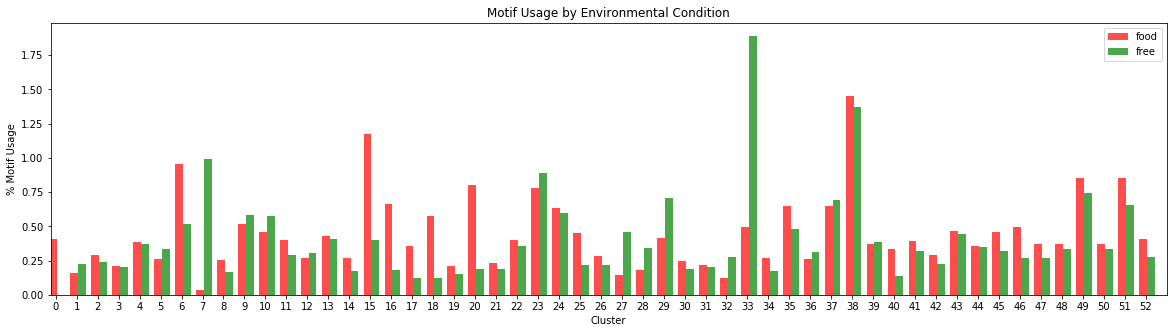

In [158]:
# Distribution figure  
cluster_id = np.arange(0,num_clusters*8)
width = 3

fig, ax = plt.subplots(figsize=(20,5)) 
ax.bar(cluster_id[0::8], env_motif['food'][2:],color='red',width=width,label='food',alpha=0.7)
ax.bar(cluster_id[3::8], env_motif['free'][2:],color='green',width=width,label='free',alpha=0.7)
ax.set(xlabel="Cluster", ylabel="% Motif Usage", title="Motif Usage by Environmental Condition", 
       xticks=cluster_id[1::8], xticklabels=np.arange(0,num_clusters).astype(int),
      xlim=[-1,num_clusters*8+1])
plt.legend()
plt.show()

# Motif Usage Scatter Plot

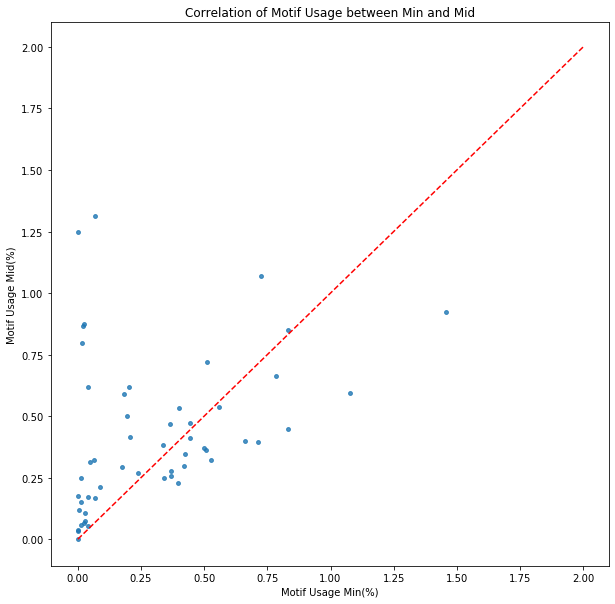

In [22]:
fig, ax = plt.subplots(figsize=(10,10)) 

linear_func = np.linspace(0,2,50)
ax.plot(linear_func,linear_func,color='r',linestyle='dashed')
ax.scatter(caste_motif['min'][2:], caste_motif['mid'][2:], s=15, alpha=0.8)

ax.set(title="Correlation of Motif Usage between Min and Mid", xlabel="Motif Usage Min(%)", ylabel="Motif Usage Mid(%)")
plt.show()

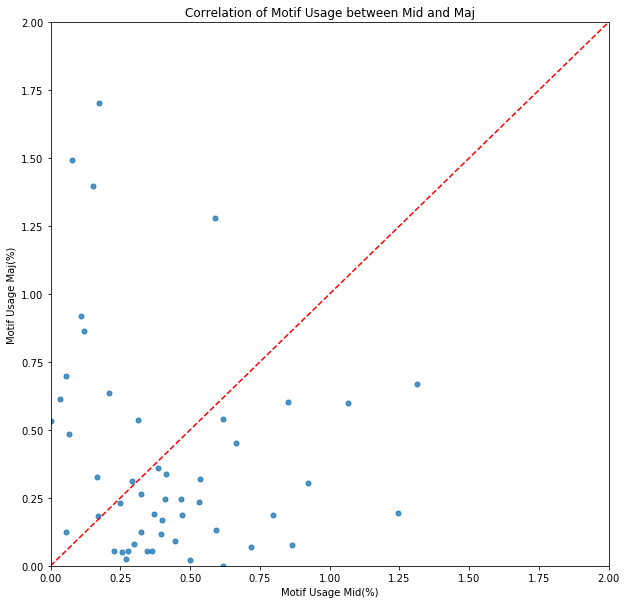

In [27]:
fig, ax = plt.subplots(figsize=(10,10)) 

linear_func = np.linspace(0,2,50)
ax.plot(linear_func,linear_func,color='r',linestyle='dashed')
ax.scatter(caste_motif['mid'][2:], caste_motif['maj'][2:], s=25, alpha=0.8)

ax.set(title="Correlation of Motif Usage between Mid and Maj", xlabel="Motif Usage Mid(%)", ylabel="Motif Usage Maj(%)"
      ,xlim=(0,2),ylim=(0,2))
plt.show()

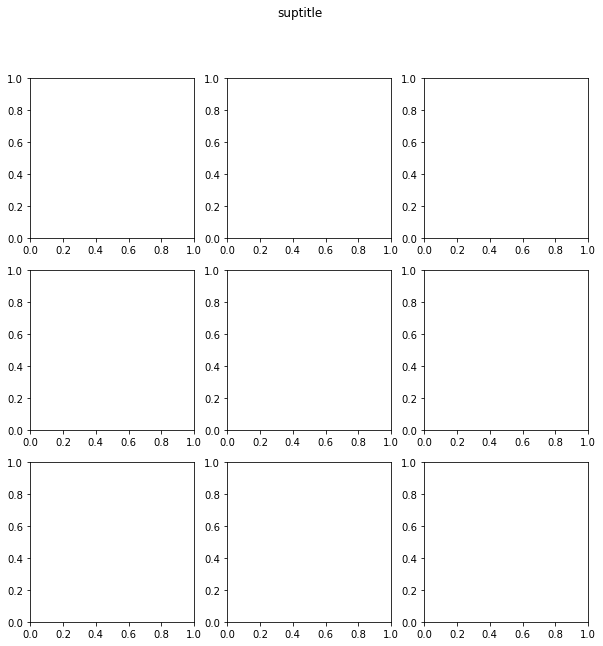

In [29]:
fig, ax = plt.subplots(3,3,figsize=(10,10)) 
fig.suptitle("suptitle")
plt.show()